In [6]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-0.14

In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [13]:
def load_fashion_mnist():
    (x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0 
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    return x_train, x_test

x_train, x_test = load_fashion_mnist()

In [19]:
def add_noise(images, noise_factor=0.4):
    noisy_images = images + noise_factor * np.random.randn(*images.shape)
    return np.clip(noisy_images, 0.0, 1.0)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [21]:
def build_dae():
    input_img = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    
    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder

dae = build_dae()

In [ ]:
dae.fit(x_train_noisy, x_train, epochs=100, batch_size=128, validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 0.0119 - val_loss: 0.0120
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 9/100
191/469 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0118

In [25]:
def compute_reconstruction_loss(model, x_noisy, x_clean):
    reconstructed = model.predict(x_noisy)
    mse_loss = np.mean(np.square(x_clean - reconstructed))
    print(f"Reconstruction Loss (MSE): {mse_loss:.6f}")
compute_reconstruction_loss(dae, x_test_noisy, x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Reconstruction Loss (MSE): 0.012451


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


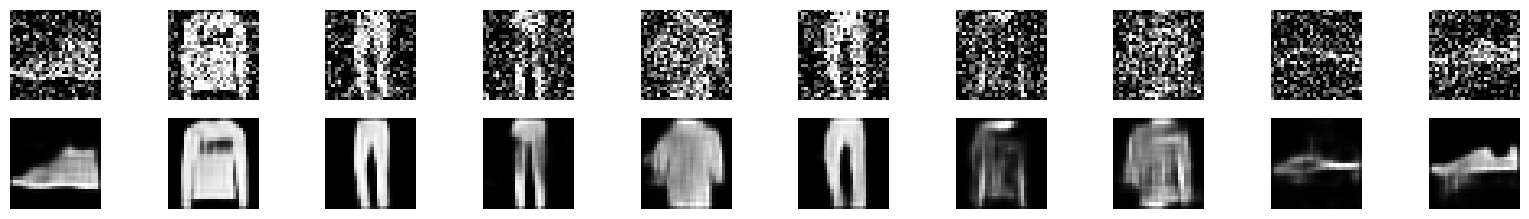

In [27]:
def show_denoising_results(model, x_noisy, x_clean, n=10):
    decoded_imgs = model.predict(x_noisy[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(x_noisy[i].squeeze(), cmap="gray")
        plt.axis("off")
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()
show_denoising_results(dae, x_test_noisy, x_test)